# Hailey Chung ECE475 Project 4 (Wine Quality)

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import os 
import sklearn

from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.model_selection import GridSearchCV

# winequality-red.csv

Chose to work on the wine quality dataset for red wines. This dataset has more features than the housing dataset, which I'm guessing makes it more complicated. 

In [3]:
# https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009?resource=download
filename = os.path.join(os.getcwd(),"winequality-red.csv")
df = pd.read_csv(filename)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [4]:
# Creating Labels and Features
y = df['quality']
X = df.drop(columns='quality',inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 723)

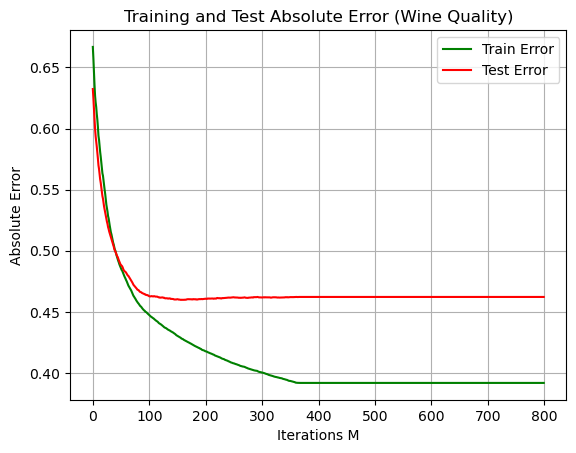

In [9]:
winexgb = xgb.XGBRegressor(max_depth = 3, learning_rate = 0.05, colsample_bytree=0.5, objective = "reg:pseudohubererror", n_estimators = 800, eval_metric = mean_absolute_error, alpha=5)

winexgb.fit(X_train, y_train, eval_set = [(X_train, y_train),(X_test, y_test)],verbose=0)
wine_errors = winexgb.evals_result()
train_error = np.array(wine_errors['validation_0']['mean_absolute_error'])
test_error = np.array(wine_errors['validation_1']['mean_absolute_error'])

# Figure 10.13 Average-absolute error as a function of number of iterations for the wine quality data
fig, ax = plt.subplots()
ax.plot(train_error, label = 'Train Error', color = 'green')
ax.plot(test_error, label = 'Test Error', color = 'red')
ax.set(xlabel='Iterations M', ylabel='Absolute Error',title='Training and Test Absolute Error (Wine Quality)')
ax.grid()
ax.legend()
plt.show()

How I tuned the model:
I first started off with 
(max_depth = 3, learning_rate = 0.1, colsample_bytree=0.05, objective = "reg:pseudohubererror", n_estimators = 800, eval_metric = mean_absolute_error, alpha=5)
which gave the plot above.

Below is the model with tuned parameters. When I changed the max_depth from 3,4,5, the differences seemed to be negligible so I kept it at 3 to make it efficient. The learning_rate was reduced to 0.05 because it reduced the difference between the train errors and the test errors. But I did not decrease further since there probably is a tradeoff.

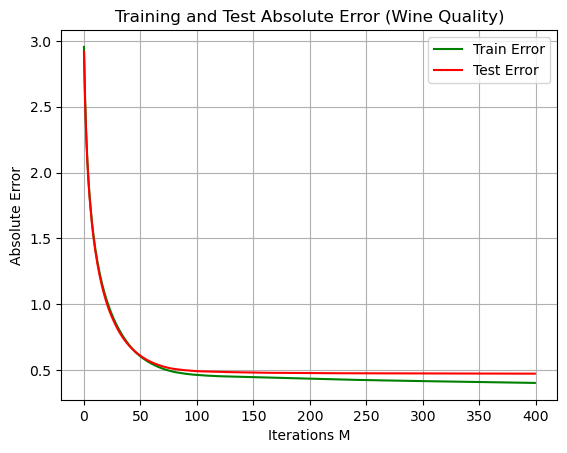

In [13]:
winexgb = xgb.XGBRegressor(max_depth = 4, learning_rate = 0.02, colsample_bytree=0.5, objective = "reg:pseudohubererror", n_estimators = 400, eval_metric = mean_absolute_error, alpha=5)

winexgb.fit(X_train, y_train, eval_set = [(X_train, y_train),(X_test, y_test)],verbose=0)
wine_errors = winexgb.evals_result()
train_error = np.array(wine_errors['validation_0']['mean_absolute_error'])
test_error = np.array(wine_errors['validation_1']['mean_absolute_error'])

# Figure 10.13 Average-absolute error as a function of number of iterations for the wine quality data
fig, ax = plt.subplots()
#M = range(0,800)
ax.plot(train_error, label = 'Train Error', color = 'green')
ax.plot(test_error, label = 'Test Error', color = 'red')
ax.set(xlabel='Iterations M', ylabel='Absolute Error',title='Training and Test Absolute Error (Wine Quality)')
ax.grid()
ax.legend()
plt.show()

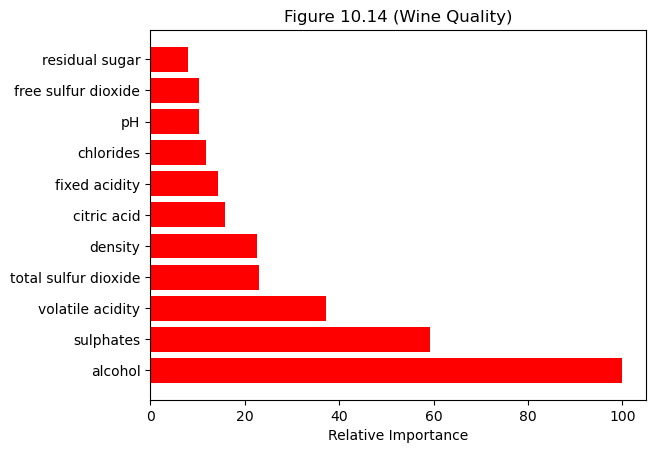

In [7]:
# Figure 10.14 Relative importance of the predictors for wine quality dataset
index = winexgb.feature_importances_.argsort()
imp = winexgb.feature_importances_[index][::-1]
relimp = (imp/max(imp))*100
feats = winexgb.feature_names_in_[index][::-1]
plt.barh(feats,relimp, color = 'red')
plt.xlabel("Relative Importance")
plt.title("Figure 10.14 (Wine Quality)")
plt.show()

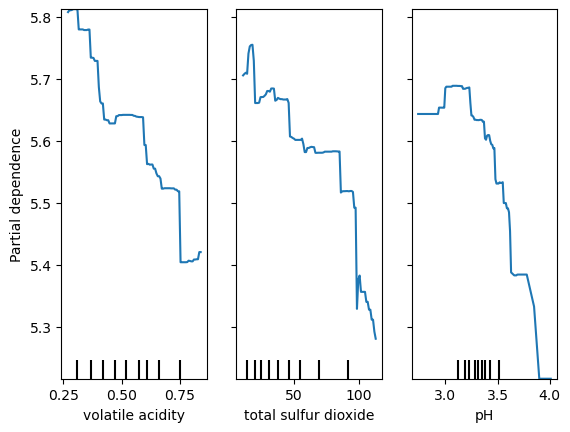

In [17]:
# FIGURE 10.15. Partial dependence of wine quality on volatile acidity, total sulfur dioxide, and pH

features = ["volatile acidity", "total sulfur dioxide", "pH"]
PartialDependenceDisplay.from_estimator(winexgb, X_train, features)

/Users/hayoonchung/opt/anaconda3/lib/python3.9/site-packages/sklearn/inspection/_partial_dependence.py:508: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(
/var/folders/zl/fxd66b555m5656g3sfpymcbr0000gn/T/ipykernel_12673/1188262647.py:11: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


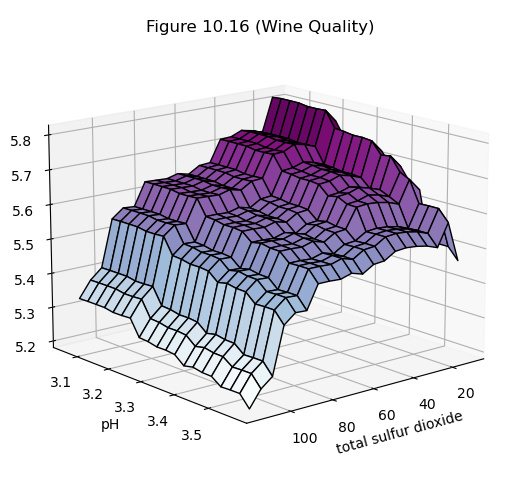

In [20]:
# Figure 10.16 Partial depencence of wine quality on total sulfur dioxide and pH

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

features2 = ["total sulfur dioxide","pH"]
pdp, axes = partial_dependence(winexgb, X_train, features2, grid_resolution=20)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor='k')

ax.set(xlabel = "total sulfur dioxide", ylabel = "pH")

ax.view_init(elev=15, azim=50)
plt.suptitle("Figure 10.16 (Wine Quality)")
plt.subplots_adjust(top=0.9)

plt.show()